# Dictionary Learning Demo
#### Simple pytorch implementation of a Dictionary Learning demo employing stochastic gradient descent, on MNIST. 

See Readme.me

Importing packages and Defining hyper-parameters

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import time
import importlib


# Hyper Parameters
EPOCH = 50
BATCH_SIZE = 256
LR = .5  # learning rate
MNT = 0.9   # momentum variable
DOWNLOAD_Dataset = True
N_TEST_IMG = 5
m = 200     # Dictionary Size

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Defining and importing training and testing data - using MNIST digits for this example

In [2]:
train_data = torchvision.datasets.MNIST(
    root='../data',
    train=True,                                     # this is training data
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                             ]),    
    download=DOWNLOAD_Dataset,                        # download it if you don't have it
)
# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

test_data = torchvision.datasets.MNIST(
    root='../data',
    train=False,                                     # this is testing data
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                             ]),
    download=DOWNLOAD_Dataset,                        # download it if you don't have it
)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

The dictionary model, as well as the dictionary learning method, is defined in Simple_DL.py file.
Here the model is initialized, we define the optimizer and the loss function to be the $\ell_2$ loss

In [3]:
import Dictionary_Model as modelDL

model = modelDL.DictLearn(m).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MNT)
loss_func = nn.MSELoss()

Beginning Training!

In [4]:
import importlib
importlib.reload(modelDL)

# Training
Error = np.zeros((EPOCH,))
Nnz = np.zeros((EPOCH,))
Loss = np.zeros((EPOCH,))
N = train_data.train_data.shape[0]
DISPLAY_FREQ = 1 ; 
TSHOW = np.round(DISPLAY_FREQ * N/BATCH_SIZE) # times per EPOCH to display information
t0 = time.perf_counter()
SC = 'fista' # 'fista' or 'IHT'
K = .7       # sparsity parameter: float numer if 'fista' or cardinality constraint if 'IHT'

Err = []

In [5]:
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):
        b_x = (x.view(-1, 28*28)).to(device)   # batch x, shape (batch, 28*28)
        b_y = (x.view(-1, 28*28)).to(device)   # batch y, shape (batch, 28*28)
        b_label = (y).to(device)               # batch label

        decoded, encoded, errIHT = model(b_x,SC,K)
        
        loss = loss_func(decoded, b_y)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients
        
        if SC == 'IHT': Loss[epoch] = Loss[epoch] + loss.data[0]
        elif SC == 'fista': Loss[epoch] = Loss[epoch] + loss.data[0] + K * np.sum(np.abs(encoded.cpu().numpy()))
        decoded = decoded.detach()
        err = np.linalg.norm( (decoded-b_x).cpu().numpy() ,'fro') / np.linalg.norm( b_x.cpu().numpy() ,'fro')
        Error[epoch] = Error[epoch] + errIHT[-1]
        Err = np.append(Err,errIHT[-1])
        Nnz[epoch] = Nnz[epoch] + np.count_nonzero(encoded.cpu().numpy())/encoded.cpu().numpy().size
        
#         # for debugging:
#         print(Error[epoch]/(step+1))
#         if step%50==0:
#             plt.plot(errIHT); plt.show()
        
    Loss[epoch] /= len(train_loader.dataset)
    Error[epoch] /= (step+1)
    Nnz[epoch] /= (step+1)
    print('Epoch: ', epoch, ', Error: ', Error[epoch], ', | train loss: %.3e' % Loss[epoch], ' NNZ/(1-sparsity): ', Nnz[epoch] )
    

C:\Users\Jere\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app


Epoch:  0 , Error:  0.410355147149 , | train loss: 5.402e+01  NNZ/(1-sparsity):  0.384422290559
Epoch:  1 , Error:  0.320617550992 , | train loss: 5.180e+01  NNZ/(1-sparsity):  0.347480219415
Epoch:  2 , Error:  0.305941495109 , | train loss: 5.046e+01  NNZ/(1-sparsity):  0.34207372008
Epoch:  3 , Error:  0.29822777738 , | train loss: 4.958e+01  NNZ/(1-sparsity):  0.337021775266
Epoch:  4 , Error:  0.29297112404 , | train loss: 4.897e+01  NNZ/(1-sparsity):  0.331691627881
Epoch:  5 , Error:  0.289224725581 , | train loss: 4.853e+01  NNZ/(1-sparsity):  0.326754931294
Epoch:  6 , Error:  0.28630467184 , | train loss: 4.817e+01  NNZ/(1-sparsity):  0.321537815824
Epoch:  7 , Error:  0.283924478546 , | train loss: 4.787e+01  NNZ/(1-sparsity):  0.316402870124
Epoch:  8 , Error:  0.281810492911 , | train loss: 4.762e+01  NNZ/(1-sparsity):  0.311705839982
Epoch:  9 , Error:  0.280045765765 , | train loss: 4.742e+01  NNZ/(1-sparsity):  0.307072722739
Epoch:  10 , Error:  0.278542138414 , | trai

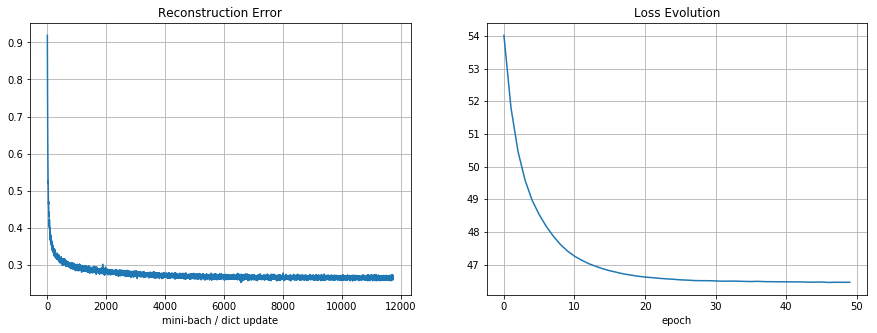

In [6]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(Err); plt.grid(); plt.title('Reconstruction Error'); plt.xlabel('mini-bach / dict update');
plt.subplot(1,2,2)
plt.plot(Loss); plt.grid(); plt.title('Loss Evolution'); plt.xlabel('epoch')
plt.show(); 

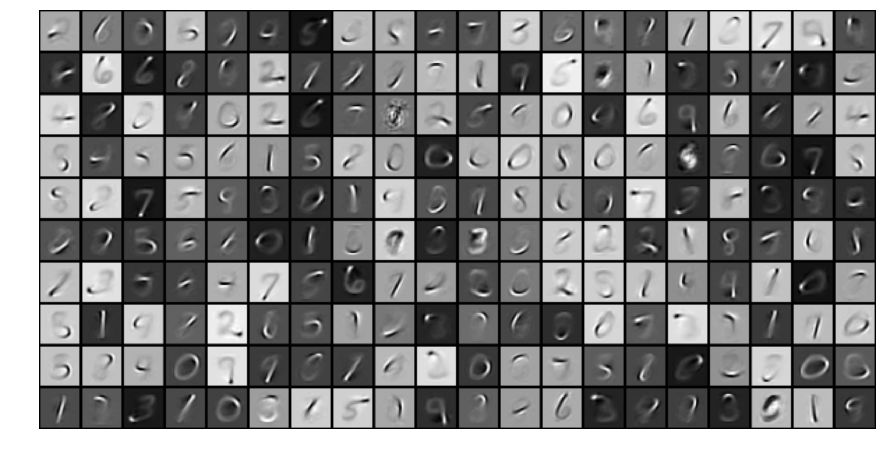

In [7]:
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

W = model.cpu().W.data.numpy().copy()

M1 = modelDL.showFilters(W,10,20)
plt.figure(figsize=(15,15))
plt.imshow(rescale(M1,4,mode='constant'),cmap='gray')
plt.axis('off')
plt.show()